## K-Means Clustering & PCA

### K-Means Clustering: The standard view

The **K-Means** algorithm takes a simple, non-probabilistic approach.
- First, pick random cluster centers $\mu_k$.

Then, repeat until convergence:

<div style="margin:10px; padding: 10px; border: 2px solid black">
**E-Step:** Assign $x_j$ to the nearest cluster center $\mu_k$,
$$
z_j = \arg\min_k || x_j - \mu_k ||^2
$$

**M-Step:** Re-estimate cluster centers by averaging over assignments:
$$
\mu_k = \frac{1}{ \# \{ j \mid z_j =k \}} \sum_{j=1}^N x_j \mathbb{I}(z_j = k)
$$
</div>

### K-Means Clustering:  The "Optimization" View

*Exercise:* Show that the K-Means algorithm finds a local minimum of the **distortion measure**, given by
$$
J(\mu_1, \ldots, \mu_k; z_1, \ldots, z_N) = \sum_{j=1}^N \sum_{k=1}^K \mathbb{I}(z_j=k) || x_j - \mu_k ||^2
$$

## Exercise: Convince yourself that K-Means = Alternating Minimization

<div style="margin:10px; padding: 10px; border: 2px solid black">
**E-Step:**
$$
(z_1, \ldots, z_N) = \arg\min_{(z_1', \ldots, z_N')} J(\mu_1, \ldots, \mu_K; z_1', \ldots, z_N')
$$

**M-Step:**
$$
(\mu_1, \ldots, \mu_K) = \arg\min_{(\mu_1', \ldots, \mu_K')} J(\mu_1', \ldots, \mu_K'; z_1, \ldots, z_N)
$$

</div>

where
$$
J(\mu_1, \ldots, \mu_k; z_1, \ldots, z_N) = \sum_{j=1}^N \sum_{k=1}^K \mathbb{I}(z_j=k) || x_j - \mu_k ||^2
$$


## Principal component analysis


### Dataset

In these first few examples and exercises we'll be working with the [UCI ML Breast Cancer Wisconsin dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic%29)



In [1]:
import pandas as pd
df = pd.read_csv(
    'wdbc.data', header=None,
    names=[
        'id', 'diagnoses',
        'mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error', 'fractal dimension error',
        'worst radius', 'worst texture', 'worst perimeter', 'worst area',
        'worst smoothness', 'worst compactness', 'worst concavity',
        'worst concave points', 'worst symmetry', 'worst fractal dimension'
    ])

df.head()

,id,diagnoses,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Let's get the features and classes into separate variables, and split the dataset into train/test sets so we can evaluate the combination of PCA and a classifier below.

In [2]:
from sklearn.cross_validation import train_test_split

X, y = df.iloc[:, 2:].values, df.iloc[:, 1].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

### Standard scaling

Before applying PCA it is important to get all of the features onto the same scale by removing the mean and scaling to unit variance.

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### Question: why only `transform` on test set?

Notice that when scaling the training set we call `fit_transform` and on the test set we call `transform`. Why is this? What would be wrong with calling `fit_transform` on `X_test`?

*your thoughts go here*

### Exercise: choosing the number of components

One question that comes up when using PCA is choosing the number of components. We wish to compress the dataset while still representing "the meat" of the data. 

The recommended technique is to look at the 'explained variance ratio' of the principal components. As we'll examine in more detail below, PCA works by constructing a matrix using the eigenvectors of the covariance matrix with the highest corresponding eigenvalues. This helps us choose the most significant 'principal components', but if we look at the ratio of the eigenvalues to the sum of all of the eigenvalues, we get a sense of what is called the explained variance of each principal component.

Let's start with [SKLearn's implementation of PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

If we don't choose the number of components, we can get the full list of eigenvalues of the covariance matrix, which will allow us to see what percentage of the variance is retained by each number of components.

In [4]:
from sklearn.decomposition import PCA

full_pca = PCA()
full_pca.fit_transform(X_train_std)

full_pca.explained_variance_ratio_

array([  4.36893153e-01,   1.94151626e-01,   9.66154484e-02,
         6.71661075e-02,   5.49883033e-02,   4.01225718e-02,
         2.18306816e-02,   1.48922601e-02,   1.37410827e-02,
         1.10137130e-02,   1.04826288e-02,   9.16214247e-03,
         7.66306051e-03,   5.14226331e-03,   3.19635178e-03,
         2.51968451e-03,   1.92415148e-03,   1.65844223e-03,
         1.49026749e-03,   1.06777316e-03,   1.01725216e-03,
         8.48954816e-04,   7.43492725e-04,   5.81295611e-04,
         5.44222785e-04,   2.53545469e-04,   2.14385701e-04,
         4.62967124e-05,   2.51158320e-05,   3.72534805e-06])

Using `full_pca.explained_variance_ratio_`, **choose the number of components that will preserve 95% of the explained variance**.

In [5]:
# change this to the minimum value that retains 95% of the explained variance
num_components = 20

### Exercise: plotting the cumulative explained variance

In addition to choosing the number of components to work with, it can be illuminating to see a plot of the explained variance of each component, but individually and cumulative. 

Plot them together below for the first 15 components.

Hint: use `plt.bar` and `plt.step`. `np.cumsum` may come in handy.

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

max_components = 15

# your code goes here


### Exercise: visualizing the dataset with the first 2 components

One benefit of PCA is that you can compress the dataset down to 2 or 3 dimensions where it can be visualized.

As we see above, the first 2 components alone retain much of the explained variance of the dataset.

**Plot the class labels against in 2 demensions using the first 2 components**. There are examples online of plotting class labels ([e.g](http://scikit-learn.org/stable/auto_examples/datasets/plot_random_multilabel_dataset.html)) in case you need pointers.

**Q:** Do the classes look linearly separable to your eye with just 2 dimensions?

In [7]:
# your code goes here

### Exercise: examining classifier performance when combined with PCA

Let's start by evaluating a logistic regression classifier on a PCA compressed dataset (using `num_components` that retains 95% variance you determined above) vs the full dataset.


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pca = PCA(n_components=num_components)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr_pca = LogisticRegression().fit(X_train_pca, y_train)

print("Logistic Regression + PCA training|test accuracy: {:.2f} | {:.2f}".format(
    accuracy_score(y_train, lr_pca.predict(X_train_pca)),
    accuracy_score(y_test, lr_pca.predict(X_test_pca))))    


lr = LogisticRegression().fit(X_train_std, y_train)
print("Logistic Regression training|test accuracy: {:.2f} | {:.2f}".format(
    accuracy_score(y_train, lr.predict(X_train_std)),
    accuracy_score(y_test, lr.predict(X_test_std))))    


Logistic Regression + PCA training|test accuracy: 0.99 | 0.98
Logistic Regression training|test accuracy: 0.99 | 0.98


As you should see, we haven't lost any predictive power in our test set by reducing the number of dimensions of our dataset substantially.

**Try adjusting the number of components down to see how it affects test set performance**. How far can we go while still acheiving reasonable accuracy? What does this tell us about the features of our dataset?

### Exercise: implement PCA using covariance matrix

Now that we've put PCA to use, let's try our hand at our own implementation.

Recall that the procedure for computing the principal components is as follows:

- Apply mean normalization and feature scaling to center values at zero
- Compute the covariance matrix
- Computer the eigenvectors of the covariance matrix
- Choose the first K columns (corresponding to eigenvectors with largest eigenvalues), call this matrix $U_{reduce}$
- To reduce feature matrix $X$ from $n$ to $k$ dimensions, compute $Z=U^T_{reduce} X$

Hint: [np.cov](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) and [np.linalg.eig](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) should come in handy.


In [9]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np

class MyPCA(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components=5):
        self.n_components = n_components
        self.u_reduce = None
    
    def fit(self, X):
        # compute u_reduce based on the eigenvectors of the co-variance matrix of X
        return self

    def transform(self, X):
        # cross multiply u_reduce transpose to X
        
        # (just returning random subset of features for dummy implementation)
        return X[:, np.random.choice(range(X.shape[1]), self.n_components, replace=False)] 

If your implementation has worked properly, you should be able to put it to use as above:

In [10]:
my_pca = MyPCA(n_components=num_components)

X_train_my_pca = my_pca.fit_transform(X_train_std)
X_test_my_pca = my_pca.transform(X_test_std)

lr_my_pca = LogisticRegression().fit(X_train_my_pca, y_train)

print("Logistic Regression + MyPCA training|test accuracy: {:.2f} | {:.2f}".format(
    accuracy_score(y_train, lr_my_pca.predict(X_train_my_pca)),
    accuracy_score(y_test, lr_my_pca.predict(X_test_my_pca))))    



Logistic Regression + MyPCA training|test accuracy: 0.99 | 0.83


### Exercise: implement PCA using SVD

Because the covariance matrix is symmetric positive semidefinite, singular value decomposition produces eigen vectors and eigenvalues. It is a more efficient procedure. Swap in SVD for `eig` and verify your PCA implementation still works. This should require only a modest adustment to your first implementation.

Hint [numpy.linalg.svd](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) should come in handy.

In [11]:
class MySVDPCA(MyPCA):
    """
    Note: we can reuse our original `transform` function.
    """
    def fit(self, X):
        # compute u_reduce based on the eigenvectors of the co-variance matrix of X
        # using SVD
        return self

Again, you should be able to see similar performance as with sklearn's PCA with your solution:

In [12]:
my_svd_pca = MySVDPCA(n_components=num_components)

X_train_my_svd_pca = my_pca.fit_transform(X_train_std)
X_test_my_svd_pca = my_pca.transform(X_test_std)

lr_my_svd_pca = LogisticRegression().fit(X_train_my_svd_pca, y_train)

print("Logistic Regression + MyPCA training|test accuracy: {:.2f} | {:.2f}".format(
    accuracy_score(y_train, lr_my_svd_pca.predict(X_train_my_svd_pca)),
    accuracy_score(y_test, lr_my_svd_pca.predict(X_test_my_svd_pca))))    


Logistic Regression + MyPCA training|test accuracy: 0.99 | 0.86


### Fun: transform and restore eigenfaces with different amounts of principal components

Once you've compressed a dataset with PCA, you can reconstruct an approximate dataset in the original dimensions using $X_{approx} = U_{reduce} Z$

Let's have some fun applying PCA on a faces dataset and show what the images look like that have had PCA applied.

In [13]:
from sklearn.datasets import fetch_olivetti_faces
faces_dataset = fetch_olivetti_faces(shuffle=True, random_state=0)
faces = faces_dataset.images.reshape(len(faces_dataset.images), -1)

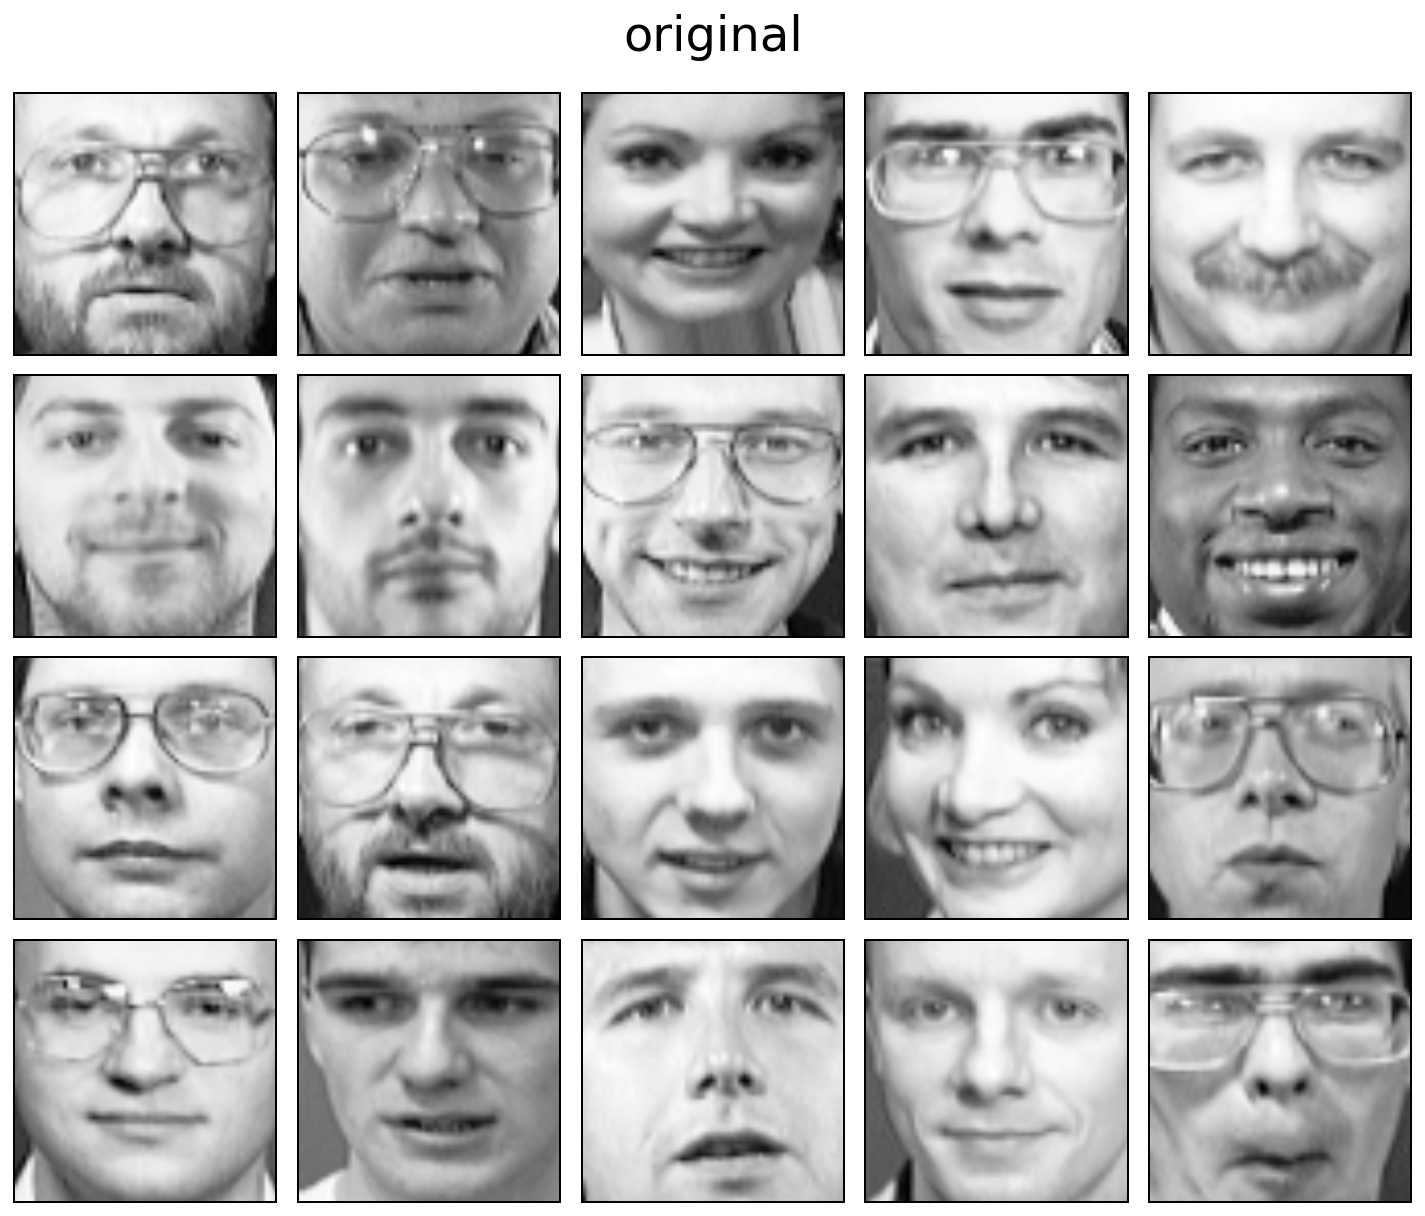

In [14]:
def plot_faces(title, faces):
    fig = plt.figure(figsize=(10, 8))
    plt.suptitle(title, y=1.05, fontsize=24)
    for i in range(20):
        sub = plt.subplot(4, 5, i + 1)
        sub.imshow(faces[i].reshape(64, 64), cmap='Greys_r')
        plt.xticks(())
        plt.yticks(())

    plt.tight_layout()
    plt.show()
    
plot_faces('original', faces)

In [15]:
from sklearn.pipeline import Pipeline

def plot_pca_faces(n_components):
    pipe_pca = Pipeline([('std', StandardScaler()),
                        ('pca', PCA(n_components=n_components))])
    compressed = pipe_pca.fit_transform(faces)
    percent_retained = np.sum(pipe_pca.steps[1][1].explained_variance_ratio_) * 100
    reconstructed = pipe_pca.inverse_transform(compressed)
    plot_faces("{} components ({:.0f}% of variance retained)".format(n_components, percent_retained), reconstructed)


There are 64\*64 = 4096 dimensions to the data. 

In [16]:
print("{} features (pixels) in each image".format(faces.shape[1]))

4096 features (pixels) in each image


Notice how with an order of magnitude fewer dimensions, 400 principal components, we still get a faithful reproduction:

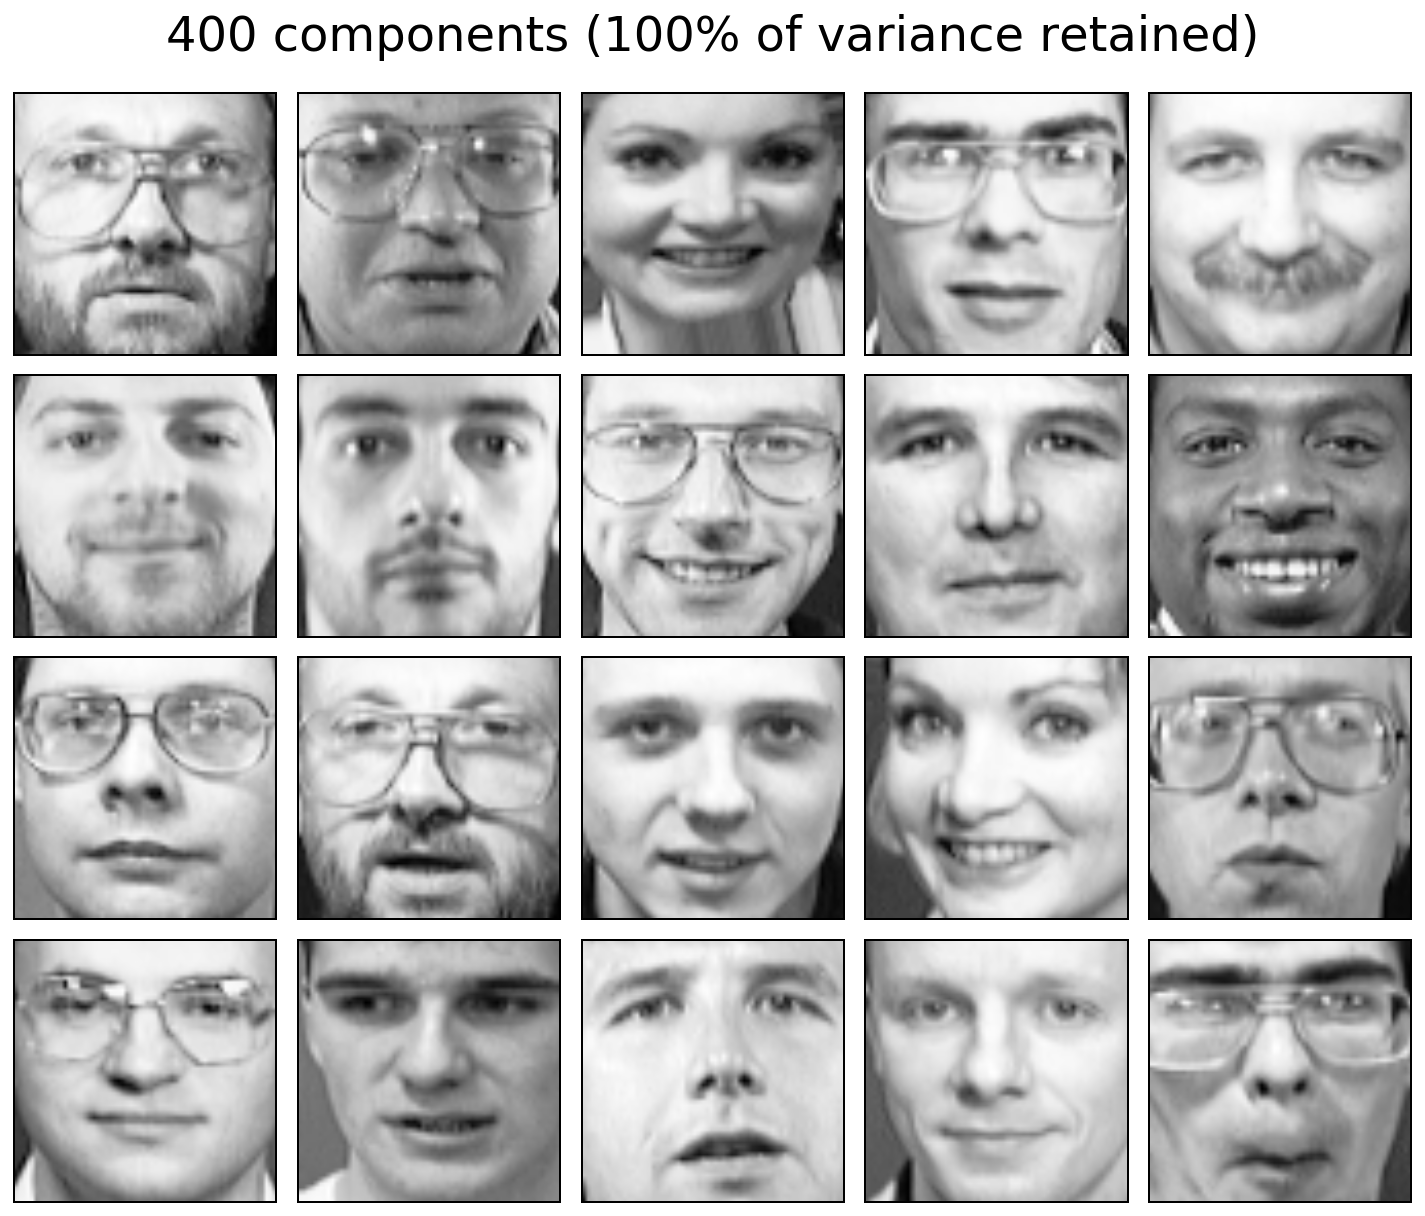

In [17]:
plot_pca_faces(400)

### Exercise: have some fun!

Try plotting faces with 100, 10 even 1 principal component and see what the images look like. It's fun to see that even with 1 principal component, the eyes are retained.

In [18]:
# have some fun e.g plot_pca_faces(100)